### Data Cleaning Data Structure

In [64]:
import csv
import sys
import json
import nltk
import re
from collections import Counter
import string
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from nltk import bigrams
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from tqdm.notebook import tqdm
import numpy as np
import math
import statistics

[nltk_data] Downloading package stopwords to C:\Users\Sun
[nltk_data]     Coliamco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Sun Coliamco\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to C:\Users\Sun
[nltk_data]     Coliamco\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Sun
[nltk_data]     Coliamco\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\Users\Sun
[nltk_data]     Coliamco\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [148]:
import pyLDAvis
import pyLDAvis.lda_model
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [65]:
class RedditPost:
    def __init__(self) -> None:
        self.Post_id         = None
        self.Id              = None
        self.Time            = None
        self.Author          = None
        self.Score           = None
        self.No_comments     = None
        self.Body            = None
        self.Type            = None
    
    def __str__(self) -> str:
        return f"{self.Post_id}, {self.Id}, {self.Time}, {self.Author}, {self.Score}, \
            {self.No_comments}, {self.Body}, {self.Type}"

# Converter function
def convert_from_tst_csv(csv_file):
    record_list: list[RedditPost] = []
    current_post_dtl = RedditPost()

    is_header = True
    header = []

    for row in csv_file:
        if is_header:
            is_header = False
            continue

        if row[2].strip() != "":
            data_type = 'Post'
        else:
            data_type = 'Comment'

        record = RedditPost()

        record.Post_id         = row[2] if data_type == 'Post' else current_post_dtl.Post_id
        record.Id              = row[2] if data_type == "Post" else row[9]
        record.Time            = datetime.fromtimestamp(float(row[5] if data_type == "Post" else row[10])).strftime('%Y-%m-%d %H:%M:%S')
        # record.time            = float(row[5] if data_type == "Post" else row[10])
        record.Author          = row[1] if data_type == "Post" else row[6]
        record.Score           = row[4] if data_type == "Post" else row[8]
        record.No_comments     = None
        record.Body            = row[0] if data_type == "Post" else row[7]
        record.Type            = data_type

        if (row[2].strip() != "") and current_post_dtl.Post_id != row[2]:
            current_post_dtl.Post_id         = row[2]

        record_list.append(record)

    # I didn't include the comment count during the extraction
    # so I have to manually count the comments by iterate the whole list
    comment_count_dict = {}
    for row in record_list:
        if row.Post_id not in comment_count_dict:
            comment_count_dict[row.Post_id] = 0
        comment_count_dict[row.Post_id] += 1

    for row in record_list:
        if row.Post_id == row.Id:
            row.No_comments = int(comment_count_dict.get(row.Post_id))
                
    print(len(record_list))
    return (header, record_list)
    

def convert_from_t20_csv(input):
    pass

def convert_from_odi_csv(input):
    pass


### File Import (execute your conversion here)

##### Test

In [66]:
reddit_test_header_list = []

with open('../../Data/Raw/hot_reddit_data_cricket_TEST.csv') as f:
    csv_file = csv.reader(f)

    reddit_test_header_list = convert_from_tst_csv(csv_file)

88588


In [67]:
len(reddit_test_header_list)

2

In [68]:
test_data_frame = pd.DataFrame([vars(x) for x in reddit_test_header_list[1]])

test_data_frame.head()

,Post_id,Id,Time,Author,Score,No_comments,Body,Type
0,1f0syen,1f0syen,2024-08-25 20:04:21,NoQuestion4045,2445,281.0,Bangladesh beats Pakistan for the first ever in Test Cricket,Post
1,1f0syen,lju4ld6,2024-08-25 20:07:28,None,1151,NaN,"Fort Rawalpindi, yet to be captured, by the home side 😔",Comment
2,1f0syen,lju9bzy,2024-08-25 20:58:53,mofucker20,289,NaN,That stat is so ridiculous. What’s even the use of such a home ground if you haven’t won a match there in last 3 years lol,Comment
3,1f0syen,ljubwki,2024-08-25 21:24:17,SquiffyRae,173,NaN,Part of the problem is Pindi is such a highway. On roads there's always the slight risk that a team accepts a draw as inevitable and switches off for just long enough that the opposition pounces (see Adelaide 2006 for example).\n\nPindi just seems like a gigantic booby trap for Pakistan. Their team can't seem to force wins on it but they certainly know how to shit the bed on it,Comment
4,1f0syen,ljvk09z,2024-08-26 02:17:08,None,48,NaN,"It's particularly risky for a team like Pakistan that does have a tendency to not have good game awareness, make silly mistakes and do meme shit. A lot of good teams would always have it in mind that a slight lapse in concentration or a bit of complacency could be big trouble but certain teams including Pakistan do have the tendency to lack such foresight.\n\nA lot of Pakistan's issues have always been mental( which actually applies to Bangladesh as well). Somebody gotta fix their mentality. Either overconfident or completely lacking confidence.",Comment


##### ODI

##### T20

### Data Cleaning and exploration

In [69]:
test_data_frame.head()

# correcting data types
test_data_frame['Time']=pd.to_datetime(test_data_frame['Time'])
test_data_frame['No_comments']=test_data_frame['No_comments'].fillna(0).astype(int)
test_data_frame['Score']=test_data_frame['Score'].fillna(0).astype(int)
test_data_frame['Author'][test_data_frame['Author'].str.lower() == "none"] = "deleted"


C:\Users\Sun Coliamco\AppData\Local\Temp\ipykernel_19620\3477093677.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_frame['Author'][test_data_frame['Author'].str.lower() == "none"] = "deleted"


In [70]:
test_data_frame.shape

(88588, 8)

In [71]:
pd.set_option('display.max_colwidth', None)

In [72]:
test_data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88588 entries, 0 to 88587
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Post_id      88588 non-null  object        
 1   Id           88588 non-null  object        
 2   Time         88588 non-null  datetime64[ns]
 3   Author       88588 non-null  object        
 4   Score        88588 non-null  int32         
 5   No_comments  88588 non-null  int32         
 6   Body         88588 non-null  object        
 7   Type         88588 non-null  object        
dtypes: datetime64[ns](1), int32(2), object(5)
memory usage: 4.7+ MB


In [73]:
# oldest vs newest post time

oldest = test_data_frame.min(axis=0)['Time']
newest = test_data_frame.max(axis=0)['Time']

print(f"Oldest post Time : {oldest}")
print(f"Newest post Time : {newest}")

newest

Oldest post Time : 2023-11-28 13:04:53
Newest post Time : 2024-10-10 09:52:35


Timestamp('2024-10-10 09:52:35')

In [74]:
# filterting data : created after '2023-12-01'
test_df_cleared = test_data_frame[test_data_frame['Time'] > '2023-12-01 00:00:00']

oldest = test_df_cleared.min(axis=0)['Time']
newest = test_df_cleared.max(axis=0)['Time']

print(f"Oldest post time : {oldest}")
print(f"Newest post time : {newest}")


Oldest post time : 2023-12-01 00:00:31
Newest post time : 2024-10-10 09:52:35


In [75]:
# calculating no of posts and comments
no_posts = test_df_cleared[test_df_cleared['Type']== "Post"].shape[0]
no_comments = test_df_cleared[test_df_cleared['Type']== "Comment"].shape[0]


# observing no of posts and comments
print(f"No of posts : {no_posts}")
print(f"No of comments : {no_comments}")
print(f"Total data : {no_posts + no_comments}")

No of posts : 216
No of comments : 87479
Total data : 87695


In [76]:
test_df_cleared.head()

,Post_id,Id,Time,Author,Score,No_comments,Body,Type
0,1f0syen,1f0syen,2024-08-25 20:04:21,NoQuestion4045,2445,281,Bangladesh beats Pakistan for the first ever in Test Cricket,Post
1,1f0syen,lju4ld6,2024-08-25 20:07:28,deleted,1151,0,"Fort Rawalpindi, yet to be captured, by the home side 😔",Comment
2,1f0syen,lju9bzy,2024-08-25 20:58:53,mofucker20,289,0,That stat is so ridiculous. What’s even the use of such a home ground if you haven’t won a match there in last 3 years lol,Comment
3,1f0syen,ljubwki,2024-08-25 21:24:17,SquiffyRae,173,0,Part of the problem is Pindi is such a highway. On roads there's always the slight risk that a team accepts a draw as inevitable and switches off for just long enough that the opposition pounces (see Adelaide 2006 for example).\n\nPindi just seems like a gigantic booby trap for Pakistan. Their team can't seem to force wins on it but they certainly know how to shit the bed on it,Comment
4,1f0syen,ljvk09z,2024-08-26 02:17:08,deleted,48,0,"It's particularly risky for a team like Pakistan that does have a tendency to not have good game awareness, make silly mistakes and do meme shit. A lot of good teams would always have it in mind that a slight lapse in concentration or a bit of complacency could be big trouble but certain teams including Pakistan do have the tendency to lack such foresight.\n\nA lot of Pakistan's issues have always been mental( which actually applies to Bangladesh as well). Somebody gotta fix their mentality. Either overconfident or completely lacking confidence.",Comment


In [77]:
grouped_by_date = test_df_cleared.groupby(test_df_cleared['Time'].dt.date).size()

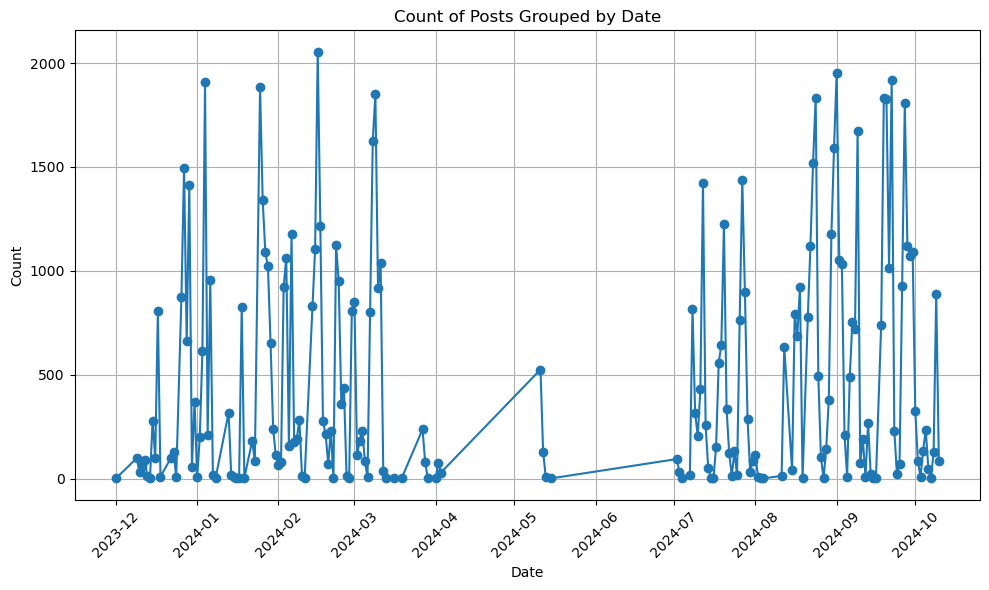

In [78]:
# plotting resutls
plt.figure(figsize=(10, 6))
grouped_by_date.plot(kind='line', marker='o')  
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Count of Posts Grouped by Date')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [79]:
# date for higher comments
# no post is more than 10000 comments because 
# I have applied a cap during data extraction due to
# unbearably slow extraction performance
# Thus, no filter is needed like the T20 case
grouped_by_date[grouped_by_date > 10000]

Series([], dtype: int64)

In [80]:
# posts with more than 500 comments
test_df_cleared[test_df_cleared['No_comments']>500]

,Post_id,Id,Time,Author,Score,No_comments,Body,Type
503,1fkb3tv,1fkb3tv,2024-09-19 13:03:19,CricketMatchBot,514,804,"Match Thread: 1st Test - India vs Bangladesh, Day 1",Post
1837,1ecqll3,1ecqll3,2024-07-27 01:14:37,Asleep_Bus_8642,850,610,Which Test era would come out on top in a match?,Post
2447,1fsm1ab,1fsm1ab,2024-09-30 13:11:17,CricketMatchBot,306,780,"Match Thread: Bangladesh v India - 2nd Test, Day 4",Post
3227,1fl2dao,1fl2dao,2024-09-20 13:02:42,CricketMatchBot,310,801,"Match Thread: 1st Test - India vs Bangladesh, Day 2",Post
4473,1flti64,1flti64,2024-09-21 13:00:29,CricketMatchBot,254,820,"Match Thread: 1st Test - India vs Bangladesh, Day 3",Post
...,...,...,...,...,...,...,...,...
80459,1epk8mt,1epk8mt,2024-08-11 23:00:23,CricketMatchBot,53,650,"Match Thread: 1st Test - South Africa vs West Indies, Day 5",Post
81485,1arpgpo,1arpgpo,2024-02-16 07:35:36,CricketMatchBot,148,825,"Match Thread: 2nd Test - South Africa vs New Zealand, Day 4",Post
82460,1eto3p1,1eto3p1,2024-08-16 22:57:39,CricketMatchBot,58,579,"Match Thread: 2nd Test - South Africa vs West Indies, Day 2",Post
83517,1aq3qrf,1aq3qrf,2024-02-14 07:33:20,CricketMatchBot,129,837,"Match Thread: 2nd Test - South Africa vs New Zealand, Day 2",Post


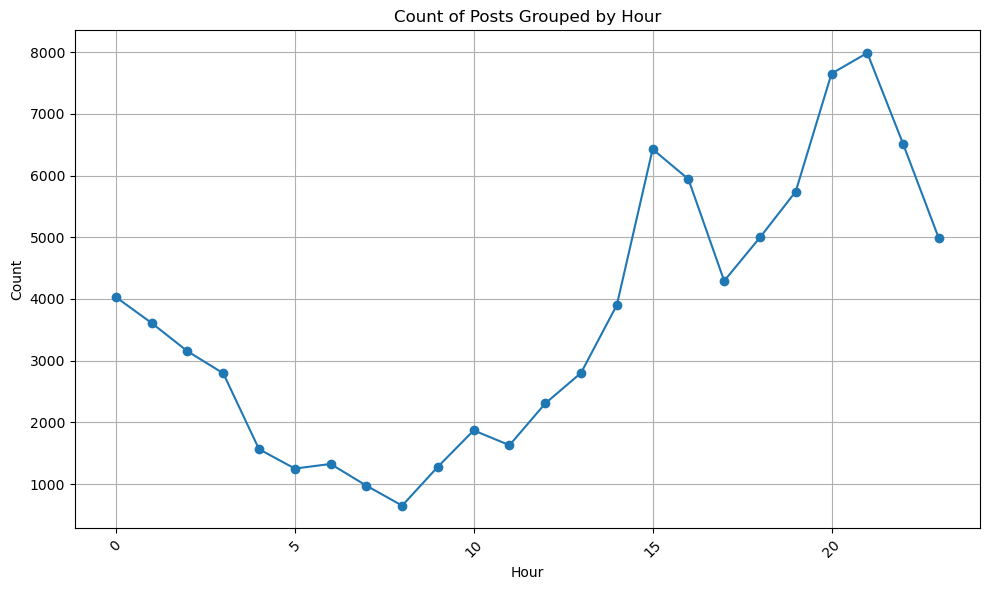

In [81]:
grouped_by_hour = test_df_cleared.groupby(test_df_cleared['Time'].dt.hour).size()

plt.figure(figsize=(10, 6))
grouped_by_hour.plot(kind='line', marker='o')  
plt.xlabel('Hour')
plt.ylabel('Count')
plt.title('Count of Posts Grouped by Hour')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [82]:
# to plot score vs no_comments without filtering data
posts = test_df_cleared[test_df_cleared['Type']=='Post']
posts.head()

,Post_id,Id,Time,Author,Score,No_comments,Body,Type
0,1f0syen,1f0syen,2024-08-25 20:04:21,NoQuestion4045,2445,281,Bangladesh beats Pakistan for the first ever in Test Cricket,Post
281,1e1g402,1e1g402,2024-07-12 22:11:38,Prof_XdR,3028,222,James Anderson's Final Test Tally against all countries,Post
503,1fkb3tv,1fkb3tv,2024-09-19 13:03:19,CricketMatchBot,514,804,"Match Thread: 1st Test - India vs Bangladesh, Day 1",Post
1307,1fmmvog,1fmmvog,2024-09-22 16:30:27,AndrewTyeFighter,1363,214,WTC table after India defeats Bangladesh in the 1st Test,Post
1521,1ftf418,1ftf418,2024-10-01 13:54:21,CricketMatchBot,369,1,"Match Thread: Bangladesh v India - 2nd Test, Day 5",Post


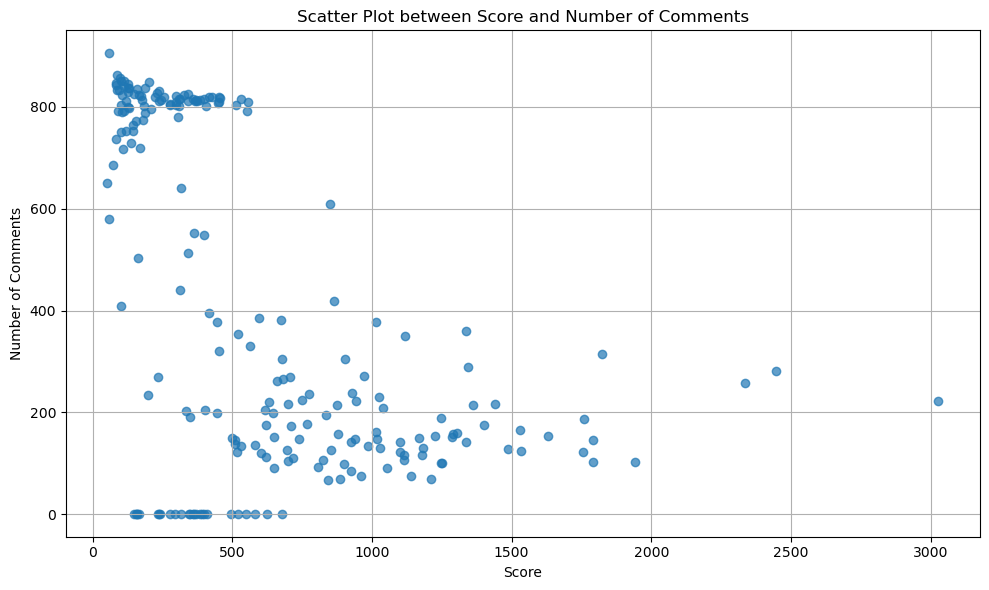

In [83]:
# score vs no_of comments
plt.figure(figsize=(10, 6))
plt.scatter(posts['Score'], posts['No_comments'], alpha=0.7)
plt.xlabel('Score')
plt.ylabel('Number of Comments')
plt.title('Scatter Plot between Score and Number of Comments')
plt.grid(True)
plt.tight_layout()
plt.show()

In [84]:
# posts with more than 4000 score
# there is none for test post
# so I decided to search for 2000
test_df_cleared[test_df_cleared['Score']>2000]

,Post_id,Id,Time,Author,Score,No_comments,Body,Type
0,1f0syen,1f0syen,2024-08-25 20:04:21,NoQuestion4045,2445,281,Bangladesh beats Pakistan for the first ever in Test Cricket,Post
281,1e1g402,1e1g402,2024-07-12 22:11:38,Prof_XdR,3028,222,James Anderson's Final Test Tally against all countries,Post
4028,1atouh6,1atouh6,2024-02-18 18:51:38,oklolzzzzs,2337,258,Yashasvi Jaiswal scores his 2nd test double century ending on 214 (236)*,Post


In [85]:
# post and comment length
post_length = []

for body in test_df_cleared['Body']:
    post_length.append(len(body))

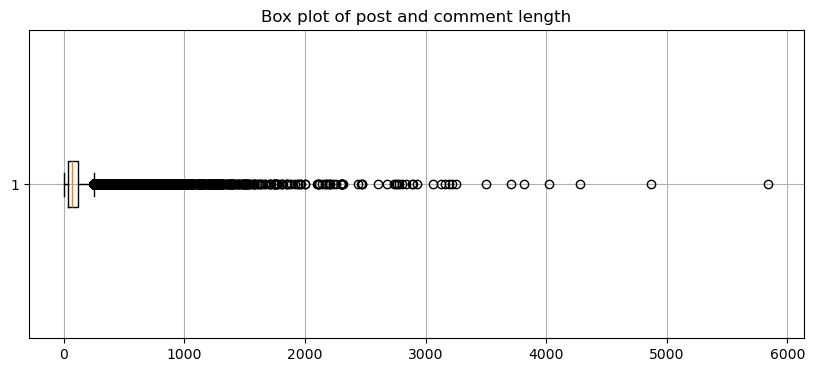

In [86]:
# visalizing post/comment length distribution
plt.figure(figsize=(10, 4))
plt.boxplot(post_length, vert=False)
plt.grid(True)
plt.title('Box plot of post and comment length')
plt.show()

In [87]:
# median value for post and comment length
median_value = statistics.median(post_length)

print(f"The median post/comment length: {median_value}")

The median post/comment length: 69


In [88]:
high_length=test_df_cleared[test_df_cleared['Body'].str.len() > 3000]
high_length

Post_id       Id                Time            Author  Score  \
2150   1ecqll3  lf2d16d 2024-07-27 03:36:16  South_Front_4589     15   
4623   1flti64  lo6n5s0 2024-09-21 19:34:01   BerozgaarVyakti     35   
6698   1fvuow2  lqeqlct 2024-10-05 14:02:43           inefekt      4   
19363  1fr7zzr  lphr2vt 2024-09-30 00:07:37        Classymuch      2   
31072  1e66usj  ldrrspl 2024-07-18 23:48:20           VisRock     17   
32685  1dxft1u  lc184c8 2024-07-07 22:54:16        Tempo24601     16   
32932  1fqenhw  lp5kxp5 2024-09-27 18:20:07            GoabNZ     45   
39977  1f5iudj  lktl2dj 2024-08-31 22:17:47          SirDoris     37   
49027  1fl2qap  lo23f75 2024-09-21 00:41:00        Classymuch      1   
58760  1dz7ygk  lcexqqw 2024-07-10 07:20:08          Socratov      1   
60743  1aryvxj  kqodykc 2024-02-16 23:26:28        beiherhund      1   
85346  18ufpmp  kfk349i 2023-12-31 01:29:17     MedicalJello2     58   
87251  1e7mrsk  le22o9o 2024-07-20 18:50:36        ianintheuk      1   

       No_comments  \
2150             0   
4623             0   
6698             0   
19363            0   
31072            0   
32685            0   
32932            0   
39977            0   
49027            0   
58760            0   
60743            0   
85346            0   
87251            0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [89]:
high_length_posts = high_length['Post_id']
high_length_posts

2150     1ecqll3
4623     1flti64
6698     1fvuow2
19363    1fr7zzr
31072    1e66usj
32685    1dxft1u
32932    1fqenhw
39977    1f5iudj
49027    1fl2qap
58760    1dz7ygk
60743    1aryvxj
85346    18ufpmp
87251    1e7mrsk
Name: Post_id, dtype: object

In [90]:
# seems I don't have any post with long content
test_df_cleared[(test_df_cleared['Post_id'].isin(high_length_posts)) & (test_df_cleared['Type'] == 'post')]

,Post_id,Id,Time,Author,Score,No_comments,Body,Type


In [91]:
# no of unique authors
num_unique_authors = test_df_cleared['Author'].nunique()
num_unique_authors

9496

In [92]:
# possible bots as authors
contains_bot = test_df_cleared['Author'].str.lower().str.contains('bot')
authors_with_bot = test_df_cleared[contains_bot]
possible_bots = authors_with_bot['Author'].unique()
possible_bots

array(['Necessary-Bother7448', 'CricketMatchBot', 'capybara_bot',
       'Own-Bother-7201', 'Both_Knowledge_807', 'AverageBottasEnjoyer',
       'botharmsinjured', 'substitute-bot', 'llobotommy', 'housebottle',
       'Both_Tennis_6033', 'Plazbot', 'SnooRobots3480', 'Tobotimus',
       'TonyAbbottsChestHair', 'fab4_bot', 'RopeBottleTowel', 'VettedBot',
       'JustAGenericBot', 'disko_robot', 'Both_Ruin_4993',
       'mr_rObOt_1807_', 'notautobot'], dtype=object)

In [93]:
actual_bots = []

for name in possible_bots:
    if not ("both" in name.lower() or "bott" in name.lower()):
        actual_bots.append(name)

actual_bots

['CricketMatchBot',
 'capybara_bot',
 'substitute-bot',
 'llobotommy',
 'Plazbot',
 'SnooRobots3480',
 'Tobotimus',
 'fab4_bot',
 'VettedBot',
 'JustAGenericBot',
 'disko_robot',
 'mr_rObOt_1807_',
 'notautobot']

In [94]:
# remove posts/comments by bots
bot_filter = (test_df_cleared['Author'].isin(actual_bots)) & (test_df_cleared['Type'] == 'Comment')
bot_filtered_df = test_df_cleared[~bot_filter]

In [95]:
before = test_df_cleared.shape
after = bot_filtered_df.shape

print(f"before: {before[0]}")
print(f"after: {after[0]}")

before: 87695
after: 87556


In [96]:
# no of unique authors
num_unique_authors_before = test_df_cleared['Author'].nunique()

num_unique_authors_after = bot_filtered_df['Author'].nunique()
print(f"before: {num_unique_authors_before}")
print(f"after: {num_unique_authors_after}")

before: 9496
after: 9484


In [97]:
# top authors

comment_count_by_author = bot_filtered_df.groupby('Author').size().reset_index(name='Comment/Post_Count')
comment_count_by_author = comment_count_by_author.sort_values(by='Comment/Post_Count', ascending=False)
comment_count_by_author.head(n=50)

,Author,Comment/Post_Count
6436,deleted,4241
5342,VisRock,865
5648,abettertomorrow47,698
1023,Classymuch,473
6314,crashbandicoochy,471
7756,mongrelbifana,453
1795,FondantAggravating68,441
3070,MedicalJello2,426
680,Benny4318,409
3418,NoExplanation6203,408


In [98]:
bot_filtered_df.head()

,Post_id,Id,Time,Author,Score,No_comments,Body,Type
0,1f0syen,1f0syen,2024-08-25 20:04:21,NoQuestion4045,2445,281,Bangladesh beats Pakistan for the first ever in Test Cricket,Post
1,1f0syen,lju4ld6,2024-08-25 20:07:28,deleted,1151,0,"Fort Rawalpindi, yet to be captured, by the home side 😔",Comment
2,1f0syen,lju9bzy,2024-08-25 20:58:53,mofucker20,289,0,That stat is so ridiculous. What’s even the use of such a home ground if you haven’t won a match there in last 3 years lol,Comment
3,1f0syen,ljubwki,2024-08-25 21:24:17,SquiffyRae,173,0,Part of the problem is Pindi is such a highway. On roads there's always the slight risk that a team accepts a draw as inevitable and switches off for just long enough that the opposition pounces (see Adelaide 2006 for example).\n\nPindi just seems like a gigantic booby trap for Pakistan. Their team can't seem to force wins on it but they certainly know how to shit the bed on it,Comment
4,1f0syen,ljvk09z,2024-08-26 02:17:08,deleted,48,0,"It's particularly risky for a team like Pakistan that does have a tendency to not have good game awareness, make silly mistakes and do meme shit. A lot of good teams would always have it in mind that a slight lapse in concentration or a bit of complacency could be big trouble but certain teams including Pakistan do have the tendency to lack such foresight.\n\nA lot of Pakistan's issues have always been mental( which actually applies to Bangladesh as well). Somebody gotta fix their mentality. Either overconfident or completely lacking confidence.",Comment


In [99]:
# defining a function to tokenize data
def data_tokenizer(text, tokenizer):

    token_list = tokenizer.tokenize(text)
    token_list = [token.strip() for token in token_list]

    return token_list

In [100]:
# initializing the necessary components
tokenizer = nltk.tokenize.TweetTokenizer()
punctuations = list(string.punctuation)
lStopwords = nltk.corpus.stopwords.words('english') + punctuations + ['...','']
stemmer = nltk.stem.PorterStemmer()
lemmatizer = WordNetLemmatizer()
vader_analyzer = SentimentIntensityAnalyzer()

In [101]:
# defining the dictionary for pos tag mapping
pos_map = {'ADJ':'a','ADP':'s','ADV':'r','NOUN':'n','VERB':'v'}

In [102]:
# generating tokens

# to store tokens
tokens =[]

# defining a counter to count the tokens
termFreqCounter = Counter()

for body in bot_filtered_df['Body']:
    temp_tokens = data_tokenizer(body,tokenizer)
    tokens.append(temp_tokens)
    termFreqCounter.update(temp_tokens)

In [103]:
# checking tokens list
tokens[1]

['Fort',
 'Rawalpindi',
 ',',
 'yet',
 'to',
 'be',
 'captured',
 ',',
 'by',
 'the',
 'home',
 'side',
 '😔']

In [104]:
# observing token counts for 50 most common tokens
for term, count in termFreqCounter.most_common(50):
    print(term + ': ' + str(count))

.: 76765
the: 60217
,: 44345
a: 37742
to: 36612
in: 29608
and: 29321
of: 24451
is: 23970
I: 20089
for: 16933
that: 16729
it: 14133
’: 13361
?: 12523
he: 12176
be: 10924
on: 10920
this: 10914
was: 10683
have: 10211
you: 9323
at: 9191
with: 8801
but: 8745
not: 8156
his: 8071
are: 7432
they: 7406
as: 7276
like: 6670
test: 6559
just: 6552
has: 6521
": 6436
s: 6296
we: 5890
out: 5886
): 5785
(: 5642
so: 5594
all: 5383
if: 5278
from: 5170
!: 5105
him: 5097
get: 4950
cricket: 4943
one: 4934
can: 4826


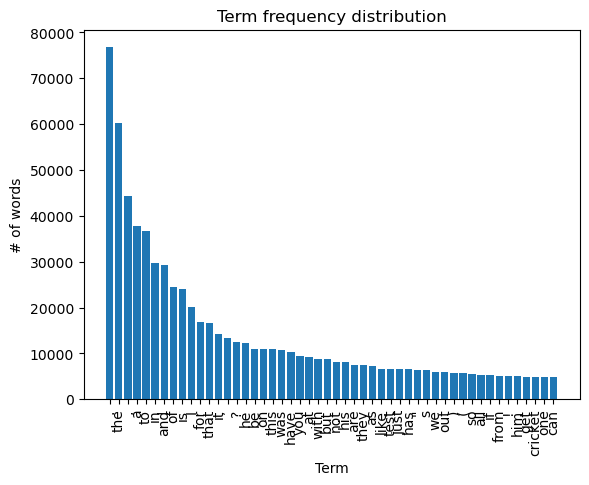

In [105]:
# plotting most common term counts
y = [count for tag, count in termFreqCounter.most_common(50)]
x = [tag for tag, count in termFreqCounter.most_common(50)]

plt.bar(x, y)
plt.title("Term frequency distribution")
plt.ylabel('# of words')
plt.xlabel('Term')
plt.xticks(rotation = 90)
plt.show()

In [106]:
# defining a function for pre-processing

def preprocessor_lemmatizer(text):
    # remove unicode character
    text = re.sub(u"(\u2018|\u2019|\u2014|\u2026|\u201d|\u201c|\ud83e|\udd14|U+002E|U+002E|=/|\.{2,})", "",text)
    # tokenization
    token_list = tokenizer.tokenize(text)
    # strip white spaces
    token_list = [token.strip() for token in token_list]
    # converting to lowercase
    token_list = [token.lower() for token in token_list]

    # to identify numbers (both decimal and real numbers)
    digit_pattern = re.compile(r"\b\d+(\.\d+)?\b")
    # to identify links
    link_pattern = re.compile(r'^http.*|.*\.com|^www.*')
    # to identify tokens with mixed letters and digits
    digit_letter_mix_pattern = re.compile(r"^(?=.*[A-Za-z])(?=.*\d)[A-Za-z\d]+$")

    token_list = [token for token in token_list if token not in lStopwords and digit_pattern.match(token) == None and link_pattern.match(token) == None and digit_letter_mix_pattern.match(token) == None and token.strip()]

    # identify pos tags
    tags = pos_tag(token_list, tagset='universal')

    # mapping to a readble pos tag format for lemmatizer
    tags = [(token,pos_map[tag] if tag in pos_map.keys() else 'n')for (token,tag) in tags]

    # lemmatizations
    token_list = [lemmatizer.lemmatize(token,tag) for (token,tag) in tags]
    
    # remove single letter tokens
    token_list = [token for token in token_list if len(token)>1]

    return token_list

In [107]:
# applying pre-processing

# defining a counter to count the frequency of tokens
termFreqCounter = Counter()

preprocessed_tokens = []

for body in tqdm(bot_filtered_df['Body']):
    temp_tokens = preprocessor_lemmatizer(body)
    preprocessed_tokens.append(temp_tokens)
    termFreqCounter.update(temp_tokens)

  0%|          | 0/87556 [00:00<?, ?it/s]

In [108]:
# observing token counts for 50 most common tokens
for term, count in termFreqCounter.most_common(200):
    print(term + ': ' + str(count))

test: 11375
get: 10767
play: 7579
like: 7183
good: 5998
go: 5896
one: 5655
cricket: 5582
team: 5200
time: 5064
well: 5016
match: 4947
think: 4939
india: 4839
bat: 4697
england: 4664
would: 4635
make: 4370
day: 4325
run: 4324
ball: 4228
see: 4125
say: 4074
wicket: 3969
even: 3815
series: 3653
take: 3647
bowl: 3644
look: 3506
average: 3362
inning: 3284
game: 3281
score: 3281
year: 3259
first: 3188
win: 3155
need: 3130
pitch: 2942
player: 2891
he's: 2891
last: 2836
really: 2768
know: 2743
give: 2739
bowler: 2723
still: 2722
come: 2710
best: 2584
also: 2564
australia: 2521
much: 2411
great: 2377
back: 2337
fuck: 2305
watch: 2245
home: 2220
way: 2205
could: 2079
nz: 2067
root: 2065
want: 2042
lose: 2039
that's: 1996
lol: 1995
bad: 1959
thing: 1884
away: 1863
pakistan: 1839
i'm: 1832
yeah: 1828
point: 1823
new: 1770
right: 1753
never: 1747
every: 1739
two: 1736
end: 1711
people: 1704
guy: 1692
start: 1654
man: 1639
batter: 1626
over: 1607
big: 1575
top: 1540
shit: 1443
love: 1443
can't: 1442

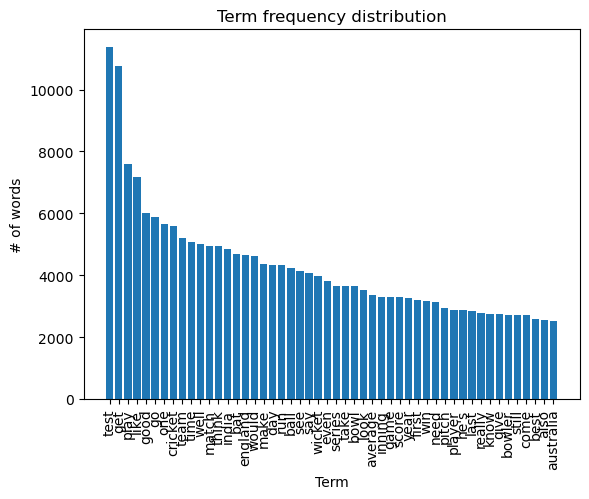

In [109]:
# plotting most common term counts
y = [count for tag, count in termFreqCounter.most_common(50)]
x = [tag for tag, count in termFreqCounter.most_common(50)]

plt.bar(x, y)
plt.title("Term frequency distribution")
plt.ylabel('# of words')
plt.xlabel('Term')
plt.xticks(rotation = 90)
plt.show()

In [110]:
preprocessed_tokens[2]

['stat',
 'ridiculous',
 'whats',
 'even',
 'use',
 'home',
 'ground',
 'havent',
 'match',
 'last',
 'year',
 'lol']

In [111]:
joinned_tokens = [" ".join(tokens) for tokens in preprocessed_tokens]

In [112]:
bot_filtered_df.loc[:, 'Processed_1'] = joinned_tokens

C:\Users\Sun Coliamco\AppData\Local\Temp\ipykernel_19620\182981968.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bot_filtered_df.loc[:, 'Processed_1'] = joinned_tokens


In [113]:
bot_filtered_df.head()

,Post_id,Id,Time,Author,Score,No_comments,Body,Type,Processed_1
0,1f0syen,1f0syen,2024-08-25 20:04:21,NoQuestion4045,2445,281,Bangladesh beats Pakistan for the first ever in Test Cricket,Post,bangladesh beat pakistan first ever test cricket
1,1f0syen,lju4ld6,2024-08-25 20:07:28,deleted,1151,0,"Fort Rawalpindi, yet to be captured, by the home side 😔",Comment,fort rawalpindi yet capture home side
2,1f0syen,lju9bzy,2024-08-25 20:58:53,mofucker20,289,0,That stat is so ridiculous. What’s even the use of such a home ground if you haven’t won a match there in last 3 years lol,Comment,stat ridiculous whats even use home ground havent match last year lol
3,1f0syen,ljubwki,2024-08-25 21:24:17,SquiffyRae,173,0,Part of the problem is Pindi is such a highway. On roads there's always the slight risk that a team accepts a draw as inevitable and switches off for just long enough that the opposition pounces (see Adelaide 2006 for example).\n\nPindi just seems like a gigantic booby trap for Pakistan. Their team can't seem to force wins on it but they certainly know how to shit the bed on it,Comment,part problem pindi highway road there's always slight risk team accepts draw inevitable switch long enough opposition pounce see adelaide example pindi seem like gigantic booby trap pakistan team can't seem force win certainly know shit bed
4,1f0syen,ljvk09z,2024-08-26 02:17:08,deleted,48,0,"It's particularly risky for a team like Pakistan that does have a tendency to not have good game awareness, make silly mistakes and do meme shit. A lot of good teams would always have it in mind that a slight lapse in concentration or a bit of complacency could be big trouble but certain teams including Pakistan do have the tendency to lack such foresight.\n\nA lot of Pakistan's issues have always been mental( which actually applies to Bangladesh as well). Somebody gotta fix their mentality. Either overconfident or completely lacking confidence.",Comment,particularly risky team like pakistan tendency good game awareness make silly mistake meme shit lot good team would always mind slight lapse concentration bit complacency could big trouble certain team include pakistan tendency lack foresight lot pakistan's issue always mental actually applies bangladesh well somebody gotta fix mentality either overconfident completely lack confidence


In [114]:
# defining a pre-processor for vader
def vader_pre_processor(text):
    tokens = tokenizer.tokenize(text)

    # removing digits
    digit_pattern = re.compile(r"\b\d+(\.\d+)?\b")
    # removing links
    link_pattern = re.compile(r'^http.*|.*\.com|^www.*')

    # filtering tokens
    tokens = [token.strip() for token in tokens if digit_pattern.match(token)==None and link_pattern.match(token)==None and token.strip()]

    # joining tokens togeter
    text = ' '.join(tokens)

    return text

In [115]:
# applying vader preprocessing
vader_tokens = []

for body in tqdm(bot_filtered_df['Body']):
    temp_tokens = vader_pre_processor(body)
    vader_tokens.append(temp_tokens)

  0%|          | 0/87556 [00:00<?, ?it/s]

In [116]:
vader_tokens[2]

'That stat is so ridiculous . What ’ s even the use of such a home ground if you haven ’ t won a match there in last years lol'

In [117]:
bot_filtered_df.loc[:, 'Processed_2'] = vader_tokens

C:\Users\Sun Coliamco\AppData\Local\Temp\ipykernel_19620\327286274.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bot_filtered_df.loc[:, 'Processed_2'] = vader_tokens


In [121]:
bot_filtered_df.shape

(87556, 10)

In [118]:
bot_filtered_df.head()

,Post_id,Id,Time,Author,Score,No_comments,Body,Type,Processed_1,Processed_2
0,1f0syen,1f0syen,2024-08-25 20:04:21,NoQuestion4045,2445,281,Bangladesh beats Pakistan for the first ever in Test Cricket,Post,bangladesh beat pakistan first ever test cricket,Bangladesh beats Pakistan for the first ever in Test Cricket
1,1f0syen,lju4ld6,2024-08-25 20:07:28,deleted,1151,0,"Fort Rawalpindi, yet to be captured, by the home side 😔",Comment,fort rawalpindi yet capture home side,"Fort Rawalpindi , yet to be captured , by the home side 😔"
2,1f0syen,lju9bzy,2024-08-25 20:58:53,mofucker20,289,0,That stat is so ridiculous. What’s even the use of such a home ground if you haven’t won a match there in last 3 years lol,Comment,stat ridiculous whats even use home ground havent match last year lol,That stat is so ridiculous . What ’ s even the use of such a home ground if you haven ’ t won a match there in last years lol
3,1f0syen,ljubwki,2024-08-25 21:24:17,SquiffyRae,173,0,Part of the problem is Pindi is such a highway. On roads there's always the slight risk that a team accepts a draw as inevitable and switches off for just long enough that the opposition pounces (see Adelaide 2006 for example).\n\nPindi just seems like a gigantic booby trap for Pakistan. Their team can't seem to force wins on it but they certainly know how to shit the bed on it,Comment,part problem pindi highway road there's always slight risk team accepts draw inevitable switch long enough opposition pounce see adelaide example pindi seem like gigantic booby trap pakistan team can't seem force win certainly know shit bed,Part of the problem is Pindi is such a highway . On roads there's always the slight risk that a team accepts a draw as inevitable and switches off for just long enough that the opposition pounces ( see Adelaide for example ) . Pindi just seems like a gigantic booby trap for Pakistan . Their team can't seem to force wins on it but they certainly know how to shit the bed on it
4,1f0syen,ljvk09z,2024-08-26 02:17:08,deleted,48,0,"It's particularly risky for a team like Pakistan that does have a tendency to not have good game awareness, make silly mistakes and do meme shit. A lot of good teams would always have it in mind that a slight lapse in concentration or a bit of complacency could be big trouble but certain teams including Pakistan do have the tendency to lack such foresight.\n\nA lot of Pakistan's issues have always been mental( which actually applies to Bangladesh as well). Somebody gotta fix their mentality. Either overconfident or completely lacking confidence.",Comment,particularly risky team like pakistan tendency good game awareness make silly mistake meme shit lot good team would always mind slight lapse concentration bit complacency could big trouble certain team include pakistan tendency lack foresight lot pakistan's issue always mental actually applies bangladesh well somebody gotta fix mentality either overconfident completely lack confidence,"It's particularly risky for a team like Pakistan that does have a tendency to not have good game awareness , make silly mistakes and do meme shit . A lot of good teams would always have it in mind that a slight lapse in concentration or a bit of complacency could be big trouble but certain teams including Pakistan do have the tendency to lack such foresight . A lot of Pakistan's issues have always been mental ( which actually applies to Bangladesh as well ) . Somebody gotta fix their mentality . Either overconfident or completely lacking confidence ."


### sentiment analysis

In [122]:
# computing sentimenet for each comment/post
vader_sentiments = []

for index,row in tqdm(bot_filtered_df.iterrows(),total=87556):
    
    #apply pre-processing
    text = row['Processed_2']
    
    #vader polarity score
    vader_score = vader_analyzer.polarity_scores(text)
    
    #time for the comment
    comment_date = row['Time']
    
    vader_sentiments.append([comment_date, vader_score['compound']])
    

  0%|          | 0/87556 [00:00<?, ?it/s]

In [123]:
vader_sentiments[:5]

[[Timestamp('2024-08-25 20:04:21'), 0.0],
 [Timestamp('2024-08-25 20:07:28'), 0.0],
 [Timestamp('2024-08-25 20:58:53'), 0.5038],
 [Timestamp('2024-08-25 21:24:17'), -0.2732],
 [Timestamp('2024-08-26 02:17:08'), 0.2881]]

In [124]:
# converting to dataframe
test_sentiment = pd.DataFrame(vader_sentiments,columns=["Date_time","Sentiment"])
test_sentiment['Date_time']=pd.to_datetime(test_sentiment['Date_time'])
test_sentiment['Date_time']=test_sentiment['Date_time'].dt.date

#aggregating
test_sentiment_aggregated = test_sentiment.groupby('Date_time')['Sentiment'].mean().reset_index()

In [125]:
test_sentiment_aggregated.head()

,Date_time,Sentiment
0,2023-12-01,0.361200
1,2023-12-09,0.178995
2,2023-12-10,0.300772
3,2023-12-11,0.064738
4,2023-12-12,0.116673


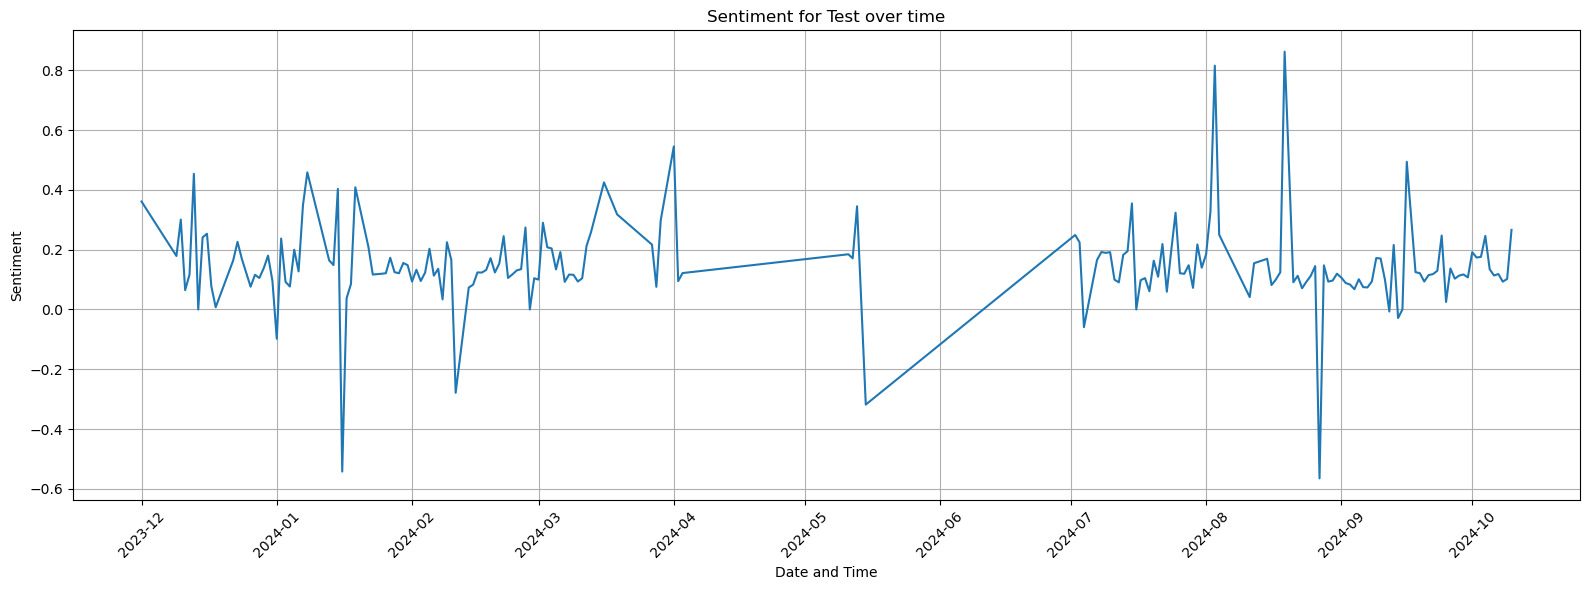

In [126]:
# plotting sentiment
plt.figure(figsize=(16, 6))
plt.plot(test_sentiment_aggregated['Date_time'],test_sentiment_aggregated['Sentiment'],linestyle='-')
plt.title('Sentiment for Test over time')
plt.xlabel('Date and Time')
plt.ylabel('Sentiment')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Finding:
# Extreme negativity on mid Jan and late August, but August also have great positivity, 

In [127]:
test_sentiment_aggregated[test_sentiment_aggregated['Sentiment']>0.5]

,Date_time,Sentiment
89,2024-04-01,0.5454
126,2024-08-03,0.8156
134,2024-08-19,0.8625


In [128]:
date_filter = ((bot_filtered_df['Time'].dt.date == datetime(2024, 4, 1).date()) | 
               (bot_filtered_df['Time'].dt.date == datetime(2024, 8, 3).date()) |
               (bot_filtered_df['Time'].dt.date == datetime(2024, 8, 19).date()))

In [129]:
high_sentiment=bot_filtered_df[date_filter]
high_sentiment

,Post_id,Id,Time,Author,Score,No_comments,Body,Type,Processed_1,Processed_2
8666,1ec9slq,lg9oufn,2024-08-03 17:44:44,Frankerian,1,0,"Thanks for that - I would love to have a specific reference; presumably a first class match, not a test match? Do you have a specific reference for me?",Comment,thanks would love specific reference presumably first class match test match specific reference,"Thanks for that - I would love to have a specific reference ; presumably a first class match , not a test match ? Do you have a specific reference for me ?"
74509,1bov8by,kxhxtc5,2024-04-01 14:53:53,Fantasy-512,1,0,"The ""average"" is notorious for overweighting outliers.\n\nMaybe you will be happy with median?",Comment,average notorious overweighting outlier maybe happy median,"The "" average "" is notorious for overweighting outliers . Maybe you will be happy with median ?"
74666,1bov8by,kxhwzwo,2024-04-01 14:46:57,Fantasy-512,1,0,Ha ha ha ha. Just because he had one good innings.,Comment,ha ha ha ha one good inning,Ha ha ha ha . Just because he had one good innings .
77499,1eu8v8t,liu3wrb,2024-08-19 16:30:07,St-Mclovin,1,0,"No one might have used the word ""Bazball"" but they constantly bring up how they are here to entertain, how others are mirroring their style of play, how they will continue to entertain irrespective of the results etc etc. I don't think any other team gets off on talking about their own playing style.",Comment,one might use word bazball constantly bring entertain others mirror style play continue entertain irrespective result etc etc think team get talk play style,"No one might have used the word "" Bazball "" but they constantly bring up how they are here to entertain , how others are mirroring their style of play , how they will continue to entertain irrespective of the results etc etc . I don't think any other team gets off on talking about their own playing style ."


In [131]:
# I also wanna address the low sentiment score as well
test_sentiment_aggregated[test_sentiment_aggregated['Sentiment']<-0.5]

,Date_time,Sentiment
31,2024-01-16,-0.5423
141,2024-08-27,-0.5651


In [132]:
date_filter = ((bot_filtered_df['Time'].dt.date == datetime(2024, 1, 16).date()) | 
               (bot_filtered_df['Time'].dt.date == datetime(2024, 8, 27).date()))

In [141]:
low_sentiment=bot_filtered_df[date_filter]
low_sentiment

,Post_id,Id,Time,Author,Score,No_comments,Body,Type,Processed_1,Processed_2
94,1f0syen,lk1za1v,2024-08-27 04:45:07,NoobSlayerr007,1,0,And Rashid Latif came to light today. What a shameless person,Comment,rashid latif come light today shameless person,And Rashid Latif came to light today . What a shameless person
182,1f0syen,lk20gry,2024-08-27 04:51:51,NoobSlayerr007,1,0,That Multan match was probably the ugliest match ever. Rashid Latif did really dirty to Cricket.,Comment,multan match probably ugly match ever rashid latif really dirty cricket,That Multan match was probably the ugliest match ever . Rashid Latif did really dirty to Cricket .
75180,1950byi,ki36vff,2024-01-16 16:59:45,deleted,1,0,I disagree tbh I think he’d get smashed around a bit by the England top order. Axar and Jadeja is where England will run into problems,Comment,disagree tbh think hed get smash around bit england top order axar jadeja england run problem,I disagree tbh I think he ’ d get smashed around a bit by the England top order . Axar and Jadeja is where England will run into problems


In [136]:
# calculate sentiment for comments selected days
t_vader_sentiments_high = []

for index,row in tqdm(high_sentiment.iterrows(),total=4):
    
    #apply pre-processing
    text = vader_pre_processor(row['Body'])
    
    #vader polarity score
    vader_score = vader_analyzer.polarity_scores(text)
    
    #time for the comment
    comment_date = row['Time']
    
    t_vader_sentiments_high.append([comment_date, vader_score['compound']])

  0%|          | 0/4 [00:00<?, ?it/s]

In [137]:
t_vader_sentiments_high

[[Timestamp('2024-08-03 17:44:44'), 0.8156],
 [Timestamp('2024-04-01 14:53:53'), 0.2023],
 [Timestamp('2024-04-01 14:46:57'), 0.8885],
 [Timestamp('2024-08-19 16:30:07'), 0.8625]]

In [139]:
# calculate sentiment for comments selected days
t_vader_sentiments_low = []

for index,row in tqdm(low_sentiment.iterrows(),total=3):
    
    #apply pre-processing
    text = vader_pre_processor(row['Body'])
    
    #vader polarity score
    vader_score = vader_analyzer.polarity_scores(text)
    
    #time for the comment
    comment_date = row['Time']
    
    t_vader_sentiments_low.append([comment_date, vader_score['compound']])

  0%|          | 0/3 [00:00<?, ?it/s]

In [140]:
t_vader_sentiments_low

[[Timestamp('2024-08-27 04:45:07'), -0.34],
 [Timestamp('2024-08-27 04:51:51'), -0.7902],
 [Timestamp('2024-01-16 16:59:45'), -0.5423]]

In [142]:
post_ids_high = high_sentiment['Post_id'].unique()
post_ids_low = low_sentiment['Post_id'].unique()

post_ids_high, post_ids_low

(array(['1ec9slq', '1bov8by', '1eu8v8t'], dtype=object),
 array(['1f0syen', '1950byi'], dtype=object))

In [143]:
bot_filtered_df[(bot_filtered_df['Post_id'].isin(post_ids_high)) & (bot_filtered_df['Type']=='Post')]

# I think I have found a bot like user which it has posted the same comment in all other posts: 98nissansentra
# I recognized ||--o--|| because he is one of the active member in the group  

,Post_id,Id,Time,Author,Score,No_comments,Body,Type,Processed_1,Processed_2
8487,1ec9slq,1ec9slq,2024-07-26 09:50:12,98nissansentra,1248,189,New cricket fan: What's going on here? I've noticed that less crazy versions of this set up happen in Test but I've not seen it in T20.,Post,new cricket fan what's go i've notice less crazy version set happen test i've see,New cricket fan : What's going on here ? I've noticed that less crazy versions of this set up happen in Test but I've not seen it in T20 .
74381,1bov8by,1bov8by,2024-03-27 17:31:42,ll--o--ll,451,320,‘We could have won three Tests’: Ollie Pope on ‘frustrating’ series loss against India,Post,could three test ollie pope frustrate series loss india,‘ We could have won three Tests ’ : Ollie Pope on ‘ frustrating ’ series loss against India
77389,1eu8v8t,1eu8v8t,2024-08-17 14:07:02,ll--o--ll,510,138,"Ultimate Bazballer Ben Duckett opens up on why he'll never change the way he plays, having faced 1,915 balls in Tests - and has only left 31",Post,ultimate bazballer ben duckett open he'll never change way play face ball test leave,"Ultimate Bazballer Ben Duckett opens up on why he'll never change the way he plays , having faced balls in Tests - and has only left"


In [144]:
bot_filtered_df[(bot_filtered_df['Post_id'].isin(post_ids_low)) & (bot_filtered_df['Type']=='Post')]

,Post_id,Id,Time,Author,Score,No_comments,Body,Type,Processed_1,Processed_2
0,1f0syen,1f0syen,2024-08-25 20:04:21,NoQuestion4045,2445,281,Bangladesh beats Pakistan for the first ever in Test Cricket,Post,bangladesh beat pakistan first ever test cricket,Bangladesh beats Pakistan for the first ever in Test Cricket
75054,1950byi,1950byi,2024-01-13 04:18:13,AmbitiousFlight2064,563,330,Team India for England Series announced - first two tests,Post,team india england series announce first two test,Team India for England Series announced - first two tests


In [ ]:
# Seems like there are some strong opinion related to Pakistan got lost with the competation.\

# However, I don't seem to see the relationship between the comment and the post 1950byi. 
# It is possibly a counter argument somewhere in the replies. 

In [145]:
comment_text = bot_filtered_df['Processed_1'].tolist()

In [146]:
comment_text[:3]

['bangladesh beat pakistan first ever test cricket',
 'fort rawalpindi yet capture home side',
 'stat ridiculous whats even use home ground havent match last year lol']

In [157]:
# creating the count vectorzer object
tfVectorizer = CountVectorizer(max_df=0.95, min_df=115, stop_words='english')
# generating the count vector
tf = tfVectorizer.fit_transform(comment_text)
# list of words in count vector
tfFeatureNames = tfVectorizer.get_feature_names_out()

In [158]:
# no of words in count vector
len(tfFeatureNames)

1003

In [159]:
# define an array to check different topic counts
num_topics = [2, 3, 5, 8, 10, 15, 20, 30]
# defining an empty array to store log-liklihood scores
log_likelihood_scores = []

# creating LDA models for each topic count and storing the log-likelihood score
for num_topic in tqdm(num_topics, total=len(num_topics)):

    ldaModel = LatentDirichletAllocation(n_components =num_topic, max_iter=10, learning_method='online',random_state=100).fit(tf)
    log_likelihood_score = ldaModel.score(tf)
    log_likelihood_scores.append([num_topic, log_likelihood_score])

c:\ProgramData\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
c:\ProgramData\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
c:\ProgramData\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
c:\ProgramData\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. P

  0%|          | 0/8 [00:00<?, ?it/s]

In [160]:
log_likelihood_scores

[[2, -3443519.669961192],
 [3, -3474666.1224053395],
 [5, -3533450.236511198],
 [8, -3584910.3792567262],
 [10, -3612789.582456343],
 [15, -3667088.169707491],
 [20, -3722513.5151145384],
 [30, -3797212.5264298464]]

In [161]:
# Similar to T20
# It can be idenetified that the log likelihood score becomes low when no of topics increases.
# Low number of topics seems more meaningful

In [162]:
# increasing min_df to 0.005
tfVectorizer = CountVectorizer(max_df=0.95, min_df=0.005, stop_words='english')
tf = tfVectorizer.fit_transform(comment_text)
tfFeatureNames = tfVectorizer.get_feature_names_out()

In [163]:
# no of words in count vector
len(tfFeatureNames)

274

In [164]:
# considering small no of topics
num_topics = [2, 3, 4, 5, 10]

# defining an empty array to store log-liklihood scores
log_likelihood_scores = []

# creating LDA models for each topic count and storing the log-likelihood score
for num_topic in tqdm(num_topics, total=len(num_topics)):

    ldaModel = LatentDirichletAllocation(n_components =num_topic, max_iter=10, learning_method='online',random_state=100).fit(tf)
    log_likelihood_score = ldaModel.score(tf)
    log_likelihood_scores.append([num_topic, log_likelihood_score])

c:\ProgramData\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
c:\ProgramData\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
c:\ProgramData\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
c:\ProgramData\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. P

  0%|          | 0/5 [00:00<?, ?it/s]

In [165]:
log_likelihood_scores

[[2, -1978712.896785499],
 [3, -2003818.7171781247],
 [4, -2020354.039880375],
 [5, -2038582.3227033815],
 [10, -2082150.914192549]]

In [166]:
# checking for topic count of 2
ldaModel = LatentDirichletAllocation(n_components =2, max_iter=10, learning_method='online', random_state=100).fit(tf)
# visualization for topic count 2
panel = pyLDAvis.lda_model.prepare(ldaModel, tf, tfVectorizer, mds='tsne')
pyLDAvis.display(panel)

In [167]:
# checking for topic count of 3
ldaModel = LatentDirichletAllocation(n_components =3, max_iter=10, learning_method='online', random_state=100).fit(tf)
# visualization for topic count 3
panel = pyLDAvis.lda_model.prepare(ldaModel, tf, tfVectorizer, mds='tsne')
pyLDAvis.display(panel)

In [168]:
# checking for topic count of 4
ldaModel = LatentDirichletAllocation(n_components =4, max_iter=10, learning_method='online', random_state=100).fit(tf)
# visualization for topic count 4
panel = pyLDAvis.lda_model.prepare(ldaModel, tf, tfVectorizer, mds='tsne')
pyLDAvis.display(panel)

In [196]:
# defining a function to compute sentiment for each topic
def topic_sentiments(topic_words,start_date,end_date):

    topic_sentiments = []

    for index,row in tqdm(bot_filtered_df.iterrows(),total=bot_filtered_df.shape[0]):

        text = row['Processed_1']

        # identifuing the key words present in the post
        if any(word in text for word in topic_words):

            vader_score = vader_analyzer.polarity_scores(row['Processed_2'])

            comment_date = row['Time']

            topic_sentiments.append([comment_date, vader_score['compound']])

    # aggregating the sentiment on daily basis
    topic_df = pd.DataFrame(topic_sentiments,columns=["Date","Sentiment"])
    topic_df['Date'] = pd.to_datetime(topic_df['Date'])
    topic_df['Date'] = topic_df['Date'].dt.date
    topic_aggregated_df = topic_df.groupby('Date')['Sentiment'].mean().reset_index()
    topic_aggregated_df['Date'] = pd.to_datetime(topic_aggregated_df['Date'])
    # defining a date filter
    date_filter = ((topic_aggregated_df['Date'] > datetime(start_date['year'], start_date['month'], start_date['day'])) & 
               (topic_aggregated_df['Date'] < datetime(end_date['year'], end_date['month'], end_date['day'])))
    #applying date filter
    topic_aggregated_df = topic_aggregated_df[date_filter]

    print(topic_aggregated_df)

    return topic_aggregated_df


def plot_multi_sentiments(topic_aggregated_df_multi):

    plt.figure(figsize=(16, 6))

    for topic_aggregated_df in topic_aggregated_df_multi:
        # creating the plot
        line = plt.plot(topic_aggregated_df[0]['Date'], topic_aggregated_df[0]['Sentiment'], linestyle='-', label = topic_aggregated_df[1])

    plt.title('Sentiment Over Time')
    plt.xlabel('Date')
    plt.ylabel('Sentiment')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()

### sentiment on Big three of Cricket for T20 matches

In [197]:
start_date = {'year': 2024, 'month': 1, 'day': 1}
end_date = {'year': 2024, 'month': 9, 'day': 27}

In [198]:
india_keywords = ['ind','india']
england_keywords = ['eng','england']
australia_keywords = ['aus','australia']

c:\ProgramData\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
c:\ProgramData\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
c:\ProgramData\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
c:\ProgramData\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. P

  0%|          | 0/87556 [00:00<?, ?it/s]

          Date  Sentiment
18  2024-01-02   0.299961
19  2024-01-03   0.168644
20  2024-01-04   0.073986
21  2024-01-05   0.297874
22  2024-01-06   0.178772
..         ...        ...
139 2024-09-22   0.138427
140 2024-09-23   0.182262
141 2024-09-24   0.271537
142 2024-09-25   0.241962
143 2024-09-26   0.222124

[126 rows x 2 columns]


c:\ProgramData\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
c:\ProgramData\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
c:\ProgramData\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
c:\ProgramData\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. P

  0%|          | 0/87556 [00:00<?, ?it/s]

          Date  Sentiment
19  2024-01-02   0.319586
20  2024-01-03   0.349721
21  2024-01-04   0.082717
22  2024-01-05   0.233363
23  2024-01-06   0.270186
..         ...        ...
135 2024-09-22   0.306366
136 2024-09-23   0.349250
137 2024-09-24   0.340400
138 2024-09-25  -0.298367
139 2024-09-26   0.365379

[121 rows x 2 columns]


c:\ProgramData\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
c:\ProgramData\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
c:\ProgramData\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
c:\ProgramData\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. P

  0%|          | 0/87556 [00:00<?, ?it/s]

          Date  Sentiment
18  2024-01-02   0.251460
19  2024-01-03   0.138625
20  2024-01-04   0.008335
21  2024-01-05   0.270038
22  2024-01-06   0.132568
..         ...        ...
135 2024-09-22   0.153968
136 2024-09-23   0.166459
137 2024-09-24   0.622020
138 2024-09-25  -0.188080
139 2024-09-26   0.105727

[122 rows x 2 columns]


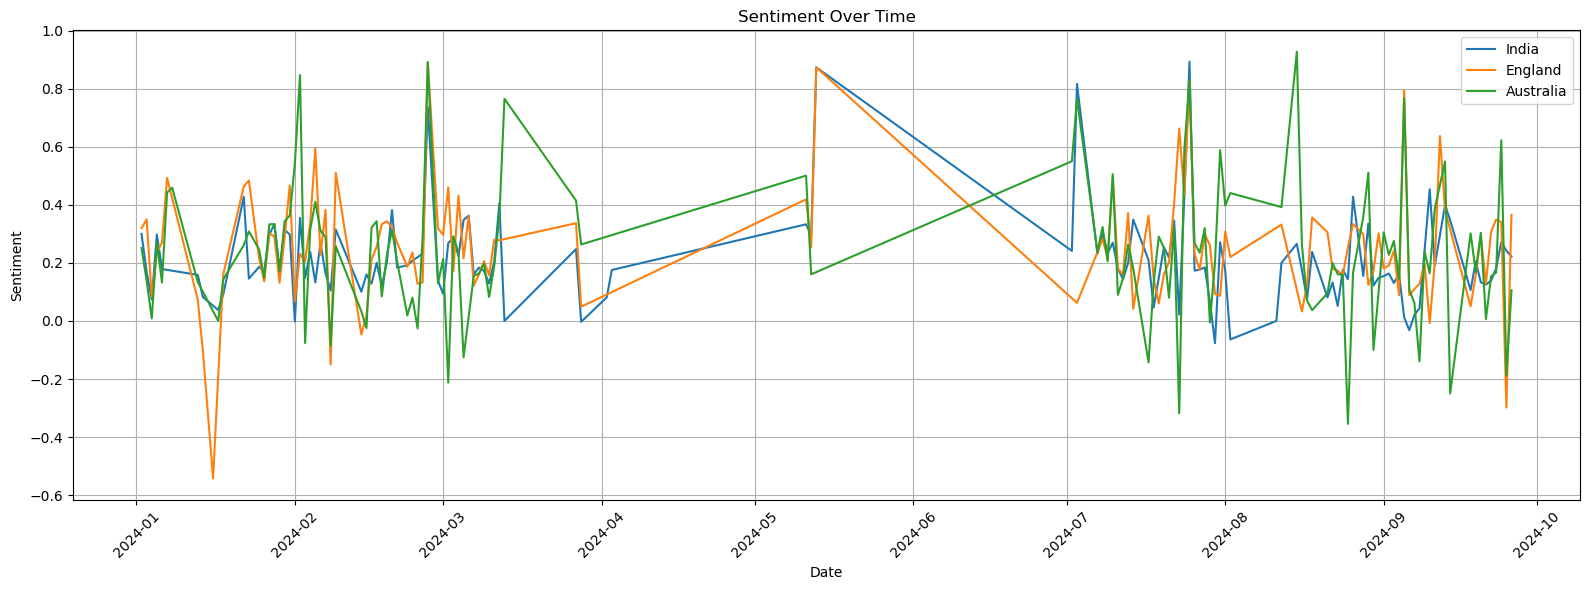

,Date,Sentiment
18,2024-01-02,0.299961
19,2024-01-03,0.168644
20,2024-01-04,0.073986
21,2024-01-05,0.297874
22,2024-01-06,0.178772
...,...,...
139,2024-09-22,0.138427
140,2024-09-23,0.182262
141,2024-09-24,0.271537
142,2024-09-25,0.241962


In [199]:
# sentiment for india

topic_aggregated_df_ind = topic_sentiments(india_keywords,start_date,end_date)
topic_aggregated_df_eng = topic_sentiments(england_keywords,start_date,end_date)
topic_aggregated_df_aus = topic_sentiments(australia_keywords,start_date,end_date)

# # plot chart:
topic_aggregated_df_list = [(topic_aggregated_df_ind, "India"), (topic_aggregated_df_eng, "England"), (topic_aggregated_df_aus, "Australia")]

plot_multi_sentiments(topic_aggregated_df_list)

topic_aggregated_df_ind

In [208]:
topic_aggregated_df_aus.sort_values(by="Sentiment", ascending=False).head(10)

,Date,Sentiment
104,2024-08-15,0.927400
58,2024-02-27,0.891000
38,2024-02-02,0.846600
94,2024-07-25,0.827100
122,2024-09-05,0.766400
71,2024-03-13,0.765000
77,2024-07-03,0.765000
137,2024-09-24,0.622020
93,2024-07-24,0.591478
100,2024-07-31,0.588208


In [225]:
date_filter = ((bot_filtered_df['Time'].dt.date == datetime(2024, 3, 13).date()))
date_filter_2 = ((test_data_frame['Time'].dt.date == datetime(2024, 3, 13).date()))

In [227]:
bot_filtered_df[date_filter]

,Post_id,Id,Time,Author,Score,No_comments,Body,Type,Processed_1,Processed_2
66298,1bbsy8r,kun87r3,2024-03-13 18:19:56,Decent_Bid_17,1,0,You guys are sure about Virat playing 2027 World Cup and expecting 30 yo Cummins to retire?,Comment,guy sure virat play world cup expect yo cummins retire,You guys are sure about Virat playing World Cup and expecting yo Cummins to retire ?
66345,1bbsy8r,kumq4an,2024-03-13 15:12:04,Deathbringer2134,1,0,Even if they win all of them they'll get points docked cause of over rate anyway lol,Comment,even win they'll get point dock cause rate anyway lol,Even if they win all of them they'll get points docked cause of over rate anyway lol
66466,1bbsy8r,kumqlg7,2024-03-13 15:16:02,Deathbringer2134,1,0,Bangladesh at home are kinda built different,Comment,bangladesh home kinda build different,Bangladesh at home are kinda built different
66521,1bbsy8r,kuiqcrj,2024-03-13 00:46:19,deleted,1,0,Weird to see Bangladesh at #4 in test ranking table. Usually occupies 8-10 throughout time.,Comment,weird see bangladesh test rank table usually occupy throughout time,Weird to see Bangladesh at # in test ranking table . Usually occupies throughout time .
66522,1bbsy8r,kumqn4f,2024-03-13 15:16:25,Deathbringer2134,1,0,Do not stop the count.,Comment,stop count,Do not stop the count .


In [228]:
bot_filtered_df[bot_filtered_df['Post_id'] == '1bbsy8r']

,Post_id,Id,Time,Author,Score,No_comments,Body,Type,Processed_1,Processed_2
66278,1bbsy8r,1bbsy8r,2024-03-11 13:57:32,AndrewTyeFighter,708,270,WTC table after Australia defeats New Zealand in the 2nd Test,Post,wtc table australia defeat new zealand test,WTC table after Australia defeats New Zealand in the 2nd Test
66279,1bbsy8r,kubewgs,2024-03-11 14:01:21,hamchan,451,0,India and Australia rematch at Lords incoming.,Comment,india australia rematch lord incoming,India and Australia rematch at Lords incoming .
66280,1bbsy8r,kubjsiz,2024-03-11 14:38:58,Leather-Initiative11,236,0,"Any chance of Cummins, Starc, Hazlewood, or Lyon taking an early retirement before the final?",Comment,chance cummins starc hazlewood lyon take early retirement final,"Any chance of Cummins , Starc , Hazlewood , or Lyon taking an early retirement before the final ?"
66281,1bbsy8r,kubk7l0,2024-03-11 14:42:23,Away-Neighborhood348,457,0,No. \n\n\nAnd we're bringing back Bradman.,Comment,we're bring back bradman,No . And we're bringing back Bradman .
66282,1bbsy8r,kubl0qm,2024-03-11 14:48:55,South_Front_4589,112,0,Ben Stokes probably wondering why we're not just picking him and backing a turnaround in his 75 year run scoring drought.,Comment,ben stoke probably wonder we're pick back turnaround year run score drought,Ben Stokes probably wondering why we're not just picking him and backing a turnaround in his year run scoring drought .
...,...,...,...,...,...,...,...,...,...,...
66543,1bbsy8r,kubsc52,2024-03-11 15:53:53,AndrewTyeFighter,2,0,"Since it is ranked on point percentage, playing more games played doesn't give any team an advantage on the table.\n\nSouth Africa seem likely to push for top 2 with the draw they have, but they play the least amount of Tests in this WTC, with six 2-Test series.",Comment,since rank point percentage play game play give team advantage table south africa seem likely push top draw play least amount test wtc six test series,"Since it is ranked on point percentage , playing more games played doesn't give any team an advantage on the table . South Africa seem likely to push for top with the draw they have , but they play the least amount of Tests in this WTC , with six - Test series ."
66544,1bbsy8r,kubvkwa,2024-03-11 16:26:22,migma21,1,0,"It’s not about advantage on the table. It’s just about the importance of test cricket. For most teams, test cricket may not be important because it doesn’t make money. It’s not economically viable to play test cricket. Hence u see them playing 4 test matches this far while some have played 10.",Comment,advantage table importance test cricket team test cricket may important doesnt make money economically viable play test cricket hence see play test match far play,"It ’ s not about advantage on the table . It ’ s just about the importance of test cricket . For most teams , test cricket may not be important because it doesn ’ t make money . It ’ s not economically viable to play test cricket . Hence u see them playing test matches this far while some have played ."
66545,1bbsy8r,kubwk5k,2024-03-11 16:36:47,AndrewTyeFighter,1,0,"Australia doesn't play any Tests for the next 8 months, yet Sri Lanka plays 7, Bangladesh 6 and NZ and Pakistan both have 5.\n\nMost of that is down to scheduling more than anything else, not prioritisation.",Comment,australia play test next month yet sri lanka play bangladesh nz pakistan schedule anything else prioritisation,"Australia doesn't play any Tests for the next months , yet Sri Lanka plays , Bangladesh and NZ and Pakistan both have . Most of that is down to scheduling more than anything else , not prioritisation ."
66546,1bbsy8r,kubwqqa,2024-03-11 16:38:46,cpssn,0,0,2 test series are huge because every series counts the same so this is as good as 5-0ing an away bgt or ashes,Comment,test series huge every series count good ing away bgt ash,test series are huge because every series counts the same so this is as good as ing an away bgt or ashes
